# Word2Vec 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models import word2vec
from gensim.models import FastText
from gensim.models import KeyedVectors
from tabulate import tabulate
from sklearn import metrics
import gspread
from oauth2client.client import GoogleCredentials
from google.colab import auth

In [ ]:
auth.authenticate_user()
gc = gspread.authorize(GoogleCredentials.get_application_default())

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
%%capture
################################################################################
# loading word embeddings
################################################################################

keyed_vector = {}
word2vec_model = word2vec.Word2Vec.load('/content/drive/My Drive/My Projects/FYP/Sentiment Lexicon/Implementation/Model1 - Word Embeddings/word2vec_model3/word2vec.model')
keyed_vector['word2vec'] = word2vec_model.wv
fasttext_model = FastText.load('/content/drive/My Drive/My Projects/FYP/Sentiment Lexicon/Implementation/Model1 - Word Embeddings/fasttext_model3/fasttext.model')
keyed_vector['fasttext'] = fasttext_model.wv

In [ ]:
################################################################################
# loading pos tags
################################################################################

pos_tagged_words_df = pd.read_csv('/content/drive/My Drive/My Projects/FYP/Sentiment Lexicon/Implementation/Model2 - Datasets/lankadeepa_pos_tagged_words.csv', header=0)
rows = pos_tagged_words_df.to_dict('split')['data']
pos_tags = {}
for row in rows:
  pos_tags[row[0]] = row[1]

In [ ]:
################################################################################
# initializing lexicon
################################################################################

spreadsheet = gc.open('Sentiment Tagged Words')
worksheet = spreadsheet.worksheet('seed_set_1')
rows = worksheet.get_all_values()

In [ ]:
################################################################################
# expanding lexicon
################################################################################
lexicon = {}
queue = []
for row in rows[1:]:
  word, score = row
  score = int(score)
  pos = score if score > 0 else 0
  neg = score if score < 0 else 0
  lexicon[word] = {'pos': pos, 'neg': neg}
  queue.append(word)

LEXICON_NAME = 'lexicon021'
LEXICON_SIZE = 10000
BRANCH_FACTOR = 8
BRANCH_THRESHOLD = 0
SIM_FACTOR = 8
SIM_THRESHOLD = 0
i = 0
while i < len(queue):
  word = queue[i]
  vec1_300 = keyed_vector['word2vec'].word_vec(word)
  vec1_25 = []
  for j in [28, 29, 42, 54, 70, 71, 80, 87, 114, 128, 152, 155, 194, 196, 204, 216, 233, 249, 254, 257, 266, 281, 289, 293, 296, 299]:
    vec1_25.append(vec1_300[j])
  similar_words = {}
  for similar_word, similarity in keyed_vector['word2vec'].most_similar(word, topn=BRANCH_FACTOR):
    # filter by branch_threshold
    if similarity < BRANCH_THRESHOLD:
      continue
    pos_tag = pos_tags.get(similar_word, 'None')
    vec2_300 = keyed_vector['word2vec'].word_vec(similar_word)
    vec2_25 = []
    for j in [28, 29, 42, 54, 70, 71, 80, 87, 114, 128, 152, 155, 194, 196, 204, 216, 233, 249, 254, 257, 266, 281, 289, 293, 296, 299]:
      vec2_25.append(vec2_300[j])
    similarity_25 = np.dot(vec1_25, vec2_25) / (np.linalg.norm(vec1_25) * np.linalg.norm(vec2_25))
    similar_words[similar_word] = {'similarity': similarity, 'pos_tag': pos_tag, 'similarity_25': similarity_25}

  top_similarity_25_values = [similar_words[similar_word]['similarity_25'] for similar_word in similar_words.keys()]
  top_similarity_25_values.sort(reverse=True)
  top_similarity_25_values = top_similarity_25_values[:SIM_FACTOR]

  for similar_word in similar_words.keys():
    similarity = similar_words[similar_word]['similarity']
    pos_tag = similar_words[similar_word]['pos_tag']
    similarity_25 = similar_words[similar_word]['similarity_25']
    # filter by sim_factor
    if similarity_25 not in top_similarity_25_values:
      continue
    # filter by sim_threshold
    if similarity_25 < SIM_THRESHOLD:
      continue
    # filter by pos tag
    if pos_tag in ['JJ', 'JCV', 'NIP', 'AUX', 'RB']:
      is_existing = lexicon.get(similar_word, 'False')
      if is_existing != 'False':
        if abs(lexicon[word]['pos']) > abs(lexicon[word]['neg']):
          lexicon[similar_word]['pos'] += 1
        elif abs(lexicon[word]['pos']) < abs(lexicon[word]['neg']):
          lexicon[similar_word]['neg'] -= 1
      else:
        if len(lexicon) == LEXICON_SIZE:
          break
        lexicon[similar_word] = {'pos': 1 if lexicon[word]['pos'] > 0 else 0, 'neg': -1 if lexicon[word]['neg'] < 0 else 0}
        queue.append(similar_word)
  i += 1
  print('\b'*(len(str(i-1)) + 1) + str(i))

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152


In [ ]:
lexicon

{'අකටයුතු': {'neg': -1, 'pos': 1},
 'අකමැති': {'neg': 0, 'pos': 1},
 'අකාලික': {'neg': 0, 'pos': 1},
 'අගනා': {'neg': 0, 'pos': 2},
 'අඥාන': {'neg': -3, 'pos': 0},
 'අතරමං': {'neg': -1, 'pos': 1},
 'අදක්ෂ': {'neg': -1, 'pos': 1},
 'අදස්': {'neg': 0, 'pos': 2},
 'අධිෂ්ඨානශීලි': {'neg': 0, 'pos': 1},
 'අනගි': {'neg': 0, 'pos': 7},
 'අනර්ඝ': {'neg': 0, 'pos': 9},
 'අන්තගාමී': {'neg': -2, 'pos': 0},
 'අන්තරාදායක': {'neg': 0, 'pos': 2},
 'අනාත': {'neg': -1, 'pos': 1},
 'අනාථ': {'neg': -1, 'pos': 1},
 'අනිවාර්ය': {'neg': -1, 'pos': 0},
 'අනුකූල': {'neg': -1, 'pos': 0},
 'අනුගත': {'neg': -6, 'pos': 0},
 'අනුබද්ධ': {'neg': -2, 'pos': 0},
 'අනුයුක්ත': {'neg': -2, 'pos': 0},
 'අනුවේදනීය': {'neg': 0, 'pos': 2},
 'අඳබාල': {'neg': -1, 'pos': 0},
 'අපක්ෂපාති': {'neg': 0, 'pos': 2},
 'අපක්ෂපාතී': {'neg': 0, 'pos': 1},
 'අපරාදේ': {'neg': -1, 'pos': 0},
 'අපහසු': {'neg': -1, 'pos': 1},
 'අපිරිසුදු': {'neg': 0, 'pos': 1},
 'අපුරු': {'neg': 0, 'pos': 2},
 'අපූරු': {'neg': 0, 'pos': 3},
 'අභීත': {'neg': 0

In [ ]:
values = []
for item in lexicon.items():
  value = [item[0], item[1]['pos'], item[1]['neg']]
  values.append(value)

In [ ]:
################################################################################
# saving lexicon
################################################################################
LEXICON_NAME = 'lexicon022'
spreadsheet = gc.open('Sentiment Tagged Words')
spreadsheet.add_worksheet(LEXICON_NAME, 2, 3)
worksheet = spreadsheet.worksheet(LEXICON_NAME)
worksheet.update_cell(1, 1, 'word')
worksheet.update_cell(1, 2, 'pos')
worksheet.update_cell(1, 3, 'neg')
spreadsheet.values_update(LEXICON_NAME + '!A2', params={'valueInputOption': 'RAW'}, body={'values': values})

{'spreadsheetId': '1G7ERCEIOPijNppbAPHSOxSBgJu8ij31ryNB1q5h2Cuo',
 'updatedCells': 1077,
 'updatedColumns': 3,
 'updatedRange': 'lexicon022!A2:C360',
 'updatedRows': 359}

In [ ]:
spreadsheet = gc.open('Sentiment Tagged Words')
worksheet = spreadsheet.worksheet('Manually Tagged Words')
col_word = worksheet.col_values(1)
col_score = worksheet.col_values(2)

lexicon_worksheet = spreadsheet.worksheet('lexicon022')
lex_word = lexicon_worksheet.col_values(1)
lex_pos = lexicon_worksheet.col_values(2)
lex_neg = lexicon_worksheet.col_values(3)

y_true_list = []
y_pred_list = []

j = len(lex_word) - 1
k = 0
for i in range(1, len(lex_word)):
  if lex_word[i] in col_word:
    true = int(col_score[col_word.index(lex_word[i])])
    pred = 1 if int(lex_pos[j]) + int(lex_neg[j]) > 0 else -1
    y_true_list.append(true)
    y_pred_list.append(pred)
    k += 1
  else:
    print('%s not found' % lex_word[i])

classification_report = metrics.classification_report(y_true_list, y_pred_list, digits=4, output_dict=True)
results = classification_report['macro avg']
results['accuracy'] = classification_report['accuracy']

rows = [
  ['Accuracy', results['accuracy']],
  ['Precision', results['precision']],
  ['Recall', results['recall']],
  ['F1-Score', results['f1-score']]
]

print('Performance for %i words out of %i words' % (k, j))
print(tabulate(rows, tablefmt='github'))

ධනවාදී not found
හැක්කේ not found
අලුත්ම not found
රසවත් not found
උතුම්ම not found
සත් not found
ආරක්ෂ not found
වන්ත not found
විධිමත් not found
සාපෙළ not found
ගණිත not found
දීර්ඝකාලීන not found
අපක්ෂපාති not found
නැතිලු not found
නරකම not found
අනුගත not found
බහුබූත not found
ගම්බද not found
පන්තික not found
නාගරික not found
නැණවත් not found
නොහැක්කේ not found
හැකිද not found
නවතම not found
කලාත්මක not found
මනරම් not found
ශාසනික not found
ස්තූතිවන්ත not found
ස්තුතිවන්ත not found
ස්ථිරසාර not found
වියයුත්තේ not found
මැදිහත්ව not found
සාමදාන not found
ලොකුමහත් not found
ධනවත් not found
අනුයුක්ත not found
අන්තගාමී not found
මුල්ම not found
බහුභූත not found
කොලබ not found
අර්ධකාලීන not found
පාන්තික not found
කෘෂිකාර්මික not found
සෑබෑ not found
පරමාදර්ශී not found
බලවත්ම not found
දුප්පත්ම not found
භයානකම not found
නිරපේක්ෂ not found
දිගුකාලීන not found
යුතුද not found
ස්කුල් not found
අළංකාර not found
රමණීය not found
අර්ථවත් not found
සතුටුදායක not found
දුක්ඛදායක not foun

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
spreadsheet = gc.open('Sentiment Tagged Words')
# worksheet = spreadsheet.worksheet('Manually Tagged Words')
# col_word = worksheet.col_values(1)
# col_score = worksheet.col_values(2)

lexicon_worksheet = spreadsheet.worksheet('lexicon021')
lex_words = lexicon_worksheet.col_values(1)
lex_pred = lexicon_worksheet.col_values(2)
# lex_pos = lexicon_worksheet.col_values(2)
# lex_neg = lexicon_worksheet.col_values(3)
lex_score = lexicon_worksheet.col_values(3)

y_true_list = []
y_pred_list = []

k = 0
for i in range(1, len(lex_words)):
  # if col_word[i] in lex_words:
    true = int(lex_score[i])
    # j = lex_words.index(lex_word[i])
    # lexicon_worksheet.update_cell(j+1, 4, true)
    # pred = 1 if int(lex_pos[i]) + int(lex_neg[i]) > 0 else -1
    pred = int(lex_pred[i])
    if true == pred:
      k += 1
    y_true_list.append(true)
    y_pred_list.append(pred)

classification_report = metrics.classification_report(y_true_list, y_pred_list, digits=4, output_dict=True)
results = classification_report['macro avg']
results['accuracy'] = classification_report['accuracy']

rows = [
  ['Accuracy', results['accuracy']],
  ['Precision', results['precision']],
  ['Recall', results['recall']],
  ['F1-Score', results['f1-score']]
]

print(tabulate(rows, tablefmt='github'))

|-----------|----------|
| Accuracy  | 0.639908 |
| Precision | 0.413632 |
| Recall    | 0.505735 |
| F1-Score  | 0.451594 |


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
x = [2,4,1]
x.sort(reverse=True)
print(x)

[4, 2, 1]


In [ ]:
print('intersection:', len(y_true_list))
print('lexicon size:', len(lexicon))

intersection: 49
lexicon size: 1000


In [ ]:
spreadsheet = gc.open('Sentiment Tagged Words')
worksheet = spreadsheet.worksheet('lexicon013')
col_word = worksheet.col_values(1)[:1000]
col_score = worksheet.col_values(2)[:1000]
col_real = worksheet.col_values(3)[:1000]

y_true_list = []
y_pred_list = []


for i in range(1, len(col_word)):
  true = int(col_real[i])
  pred = 1 if int(col_score[i]) > 0 else -1
  if true != 0:
    y_true_list.append(true)
    y_pred_list.append(pred)

classification_report = metrics.classification_report(y_true_list, y_pred_list, digits=4, output_dict=True)
results = classification_report['macro avg']
results['accuracy'] = classification_report['accuracy']

rows = [
  ['Accuracy', results['accuracy']],
  ['Precision', results['precision']],
  ['Recall', results['recall']],
  ['F1-Score', results['f1-score']]
]

print('# words', len(y_true_list))
print(tabulate(rows, tablefmt='github'))

# words 541
|-----------|----------|
| Accuracy  | 0.818854 |
| Precision | 0.820277 |
| Recall    | 0.812785 |
| F1-Score  | 0.815109 |


In [ ]:
spreadsheet = gc.open('Sentiment Tagged Words')
sheet1 = spreadsheet.worksheet('Sheet1')
sheet1_word = sheet1.col_values(1)

worksheet = spreadsheet.worksheet('lexicon012')
col_word = worksheet.col_values(1)
col_real = worksheet.col_values(3)

index = len(sheet1_word) + 1
for i in range(len(col_word)):
  if col_word[i] not in sheet1_word:
    row = [col_word[i], int(col_real[i])]
    sheet1.insert_row(row, index)
    index += 1

In [ ]:
spreadsheet = gc.open('Sentiment Tagged Words')
sheet1 = spreadsheet.worksheet('Sheet1')
sheet1_rows = sheet1.get_all_values()

real = {}
for row in sheet1_rows[1:]:
  real[row[0]] = int(row[1])

lexicon = spreadsheet.worksheet('lexicon013')
col_word = lexicon.col_values(1)

i = 653
while i < 1000:
  if col_word[i] in real:
    lexicon.update_cell(i+1, 3, real[col_word[i]])
  else:
    lexicon.update_cell(i+1, 3, '')
  print('\b'*(len(str(i-1)) + 1) + str(i))
  i += 1

653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777


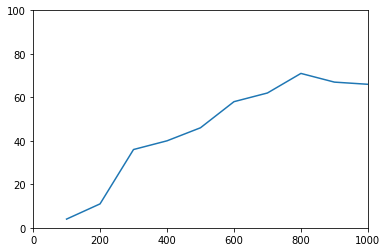

In [ ]:
spreadsheet = gc.open('Sentiment Tagged Words')
lexicon = spreadsheet.worksheet('lexicon013')
col_real = lexicon.col_values(3)

x = [i for i in range(100, 1001, 100)]
y = []
for i in range(1, 1001, 100):
  subset = col_real[i:i+101]
  n_zeros = 0
  for n in subset:
    if n == '0':
      n_zeros += 1
  y.append(n_zeros)

plt.plot(x, y)
plt.axis([0, 1000, 0, 100])
plt.show()

In [ ]:
# authenticating
import gspread
from oauth2client.client import GoogleCredentials
from google.colab import auth
auth.authenticate_user()
gc = gspread.authorize(GoogleCredentials.get_application_default())

# creating
spreadsheet = gc.create('test')
spreadsheet.add_worksheet('sheet2', 1, 1)

# reading values
spreadsheet = gc.open('gsheet name')
worksheet = spreadsheet.worksheet('Sheet1')
rows = worksheet.get_all_values()
col_values = worksheet.col_values(1)
row_values = worksheet.row_values(3)
cell = worksheet.cell(3,4)

# updating values
worksheet.update_cell(3, 3, '28')
worksheet.insert_row(row, index)

# deleting values
worksheet.delete_row(4)

In [ ]:
!pip install python-igraph

     |████████████████████████████████| 3.2MB 2.8MB/s 


In [ ]:
import igraph
from igraph import Graph, EdgeSeq
nr_vertices = 25
v_label = list(map(str, range(nr_vertices)))
G = Graph.Tree(nr_vertices, 2) # 2 stands for children number
lay = G.layout('rt')

position = {k: lay[k] for k in range(nr_vertices)}
Y = [lay[k][1] for k in range(nr_vertices)]
M = max(Y)

es = EdgeSeq(G) # sequence of edges
E = [e.tuple for e in G.es] # list of edges

L = len(position)
Xn = [position[k][0] for k in range(L)]
Yn = [2*M-position[k][1] for k in range(L)]
Xe = []
Ye = []
for edge in E:
    Xe+=[position[edge[0]][0],position[edge[1]][0], None]
    Ye+=[2*M-position[edge[0]][1],2*M-position[edge[1]][1], None]

labels = v_label

In [ ]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=Xe,
                   y=Ye,
                   mode='lines',
                   line=dict(color='rgb(210,210,210)', width=1),
                   hoverinfo='none'
                   ))
fig.add_trace(go.Scatter(x=Xn,
                  y=Yn,
                  mode='markers',
                  name='bla',
                  marker=dict(symbol='circle-dot',
                                size=18,
                                color='#6175c1',    #'#DB4551',
                                line=dict(color='rgb(50,50,50)', width=1)
                                ),
                  text=labels,
                  hoverinfo='text',
                  opacity=0.8
                  ))

# Crosslingual Lexicon Performance

In [ ]:
import numpy as np
import pandas as pd
from tabulate import tabulate
from sklearn import metrics
import gspread
from oauth2client.client import GoogleCredentials
from google.colab import auth

In [ ]:
auth.authenticate_user()
gc = gspread.authorize(GoogleCredentials.get_application_default())

In [ ]:
spreadsheet = gc.open('udyogi_2')
worksheet = spreadsheet.worksheet('embd_1_5_neighbors_1_swn')
true_words = worksheet.col_values(1)
true_scores = worksheet.col_values(3)

worksheet = spreadsheet.worksheet('embd_2_5_neighbors_1_swn')
pred_words = worksheet.col_values(1)

# crosslingual_lexicon_df = pd.read_csv('/content/drive/My Drive/My Projects/FYP/Sentiment Lexicon/Implementation/Model8 - Crosslingual/lexicons/cross_lingual_lexicon_1.csv', header=0)
# pred_words = crosslingual_lexicon_df['word']
# pred_scores = crosslingual_lexicon_df['sentiment']

for i in range(1000, len(pred_words)):
  word = pred_words[i]
  if word in true_words:
    true_score = true_scores[true_words.index(word)]
    worksheet.update_cell(i+1, 3, true_score)

# classification_report = metrics.classification_report(y_true_list, y_pred_list, digits=4, output_dict=True)
# results = classification_report['macro avg']
# results['accuracy'] = classification_report['accuracy']

# rows = [
#   ['Accuracy', results['accuracy']],
#   ['Precision', results['precision']],
#   ['Recall', results['recall']],
#   ['F1-Score', results['f1-score']]
# ]

# print(tabulate(rows, tablefmt='github'))

In [ ]:
spreadsheet = gc.open('metrics')
worksheet = spreadsheet.worksheet('seed_920_score_from_seed_5')
words = worksheet.col_values(1)
pred_scores = worksheet.col_values(3)
true_scores = worksheet.col_values(4)

y_true_list = []
y_pred_list = []

for i in range(1,len(words)):
  y_true_list.append(true_scores[i])
  y_pred_list.append(pred_scores[i])

classification_report = metrics.classification_report(y_true_list, y_pred_list, digits=4, output_dict=True)
results = classification_report['macro avg']
print(classification_report)
results['accuracy'] = classification_report['accuracy']

rows = [
  ['Accuracy', results['accuracy']],
  ['Precision', results['precision']],
  ['Recall', results['recall']],
  ['F1-Score', results['f1-score']]
]

print(tabulate(rows, tablefmt='github'))

{'-1': {'precision': 0.28888888888888886, 'recall': 0.5652173913043478, 'f1-score': 0.38235294117647056, 'support': 115}, '0': {'precision': 0.42857142857142855, 'recall': 0.02390438247011952, 'f1-score': 0.04528301886792453, 'support': 251}, '1': {'precision': 0.591304347826087, 'recall': 0.8168168168168168, 'f1-score': 0.686002522068096, 'support': 333}, 'accuracy': 0.4907010014306152, 'macro avg': {'precision': 0.4362548884288014, 'recall': 0.4686461968637614, 'f1-score': 0.3712128273708304, 'support': 699}, 'weighted avg': {'precision': 0.4831158778537021, 'recall': 0.4907010014306152, 'f1-score': 0.4059734847207713, 'support': 699}}
|-----------|----------|
| Accuracy  | 0.490701 |
| Precision | 0.436255 |
| Recall    | 0.468646 |
| F1-Score  | 0.371213 |


In [ ]:
import urllib
src = 'https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz'
dst = '/content/drive/My Drive/My Projects/FYP/Sentiment Lexicon/Implementation/GoogleNews-vectors-negative300.bin.gz'
urllib.request.urlretrieve(src, dst)

('/content/drive/My Drive/My Projects/FYP/Sentiment Lexicon/Implementation/GoogleNews-vectors-negative300.bin.gz',
 <http.client.HTTPMessage at 0x7fc27838a400>)

In [ ]:
!gunzip '/content/drive/My Drive/My Projects/FYP/Sentiment Lexicon/Implementation/GoogleNews-vectors-negative300.bin.gz'